## 加载库/初始化参数

In [2]:
import scipy.io as scio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_path = r'datasets\Train_hrrp.mat'
test_path = r'datasets\Test_hrrp.mat'
batch_size = 32
epochs = 100
epochs_log = epochs/5
learning_rate = 0.001

## 数据处理

### 可视化

In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

数据维度为： (200, 256)


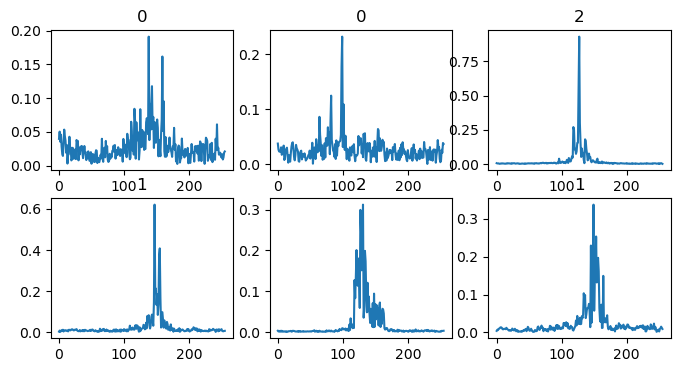

In [5]:
data_base = scio.loadmat(train_path)['aa']
hrrp = data_base[:,3:]
hrrp /= np.max(hrrp)
labels = data_base[:,0:3]  # onehot
labels = np.array([np.argmax(k) for k in labels])
print('数据维度为：',hrrp.shape)

plt.figure(figsize=(8,4))
plt.tight_layout(pad=2)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(hrrp[i])
    plt.title('{}'.format(labels[i]))

### 导入数据

In [ ]:
def get_dataloader(filepath, batch_size=8, train=True):
    # read data
    arg = 'aa' if train else 'bb'
    data_base = scio.loadmat(filepath)[arg]
    hrrp = data_base[:,3:]
    labels = data_base[:,0:3]  # onehot
    labels = np.array([np.argmax(k) for k in labels])
    
    # numpy to tensor
    hrrp = torch.tensor(hrrp,dtype=torch.float)[:,None,None,:]    # [bs,c,h,w]
    labels = torch.tensor(labels,dtype=torch.int64)

    # transform to dataloader (mini-batch)
    dataset = torch.utils.data.TensorDataset(hrrp,labels)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
    for data,labels in dataloader:
        print(data.shape,labels.shape)
        break

    return dataloader

train_dl = get_dataloader(train_path,batch_size,True)
test_dl = get_dataloader(test_path,batch_size,False)

In [ ]:
# class hrrpDataset(torch.utils.data.Dataset):
#   def __init__(self, filepath, train=True, transform=None):
#     # read data
#     arg = 'aa' if train else 'bb'
#     data_base = scio.loadmat(filepath)[arg]
#     hrrp = data_base[:,3:]
#     labels_ = data_base[:,0:3]  # onehot
#     labels = np.array([np.argmax(k) for k in labels_])
#     # numpy to tensor
#     self.hrrp = torch.tensor(hrrp,dtype=torch.float)[:,None,None,:]    # [bs,c,h,w]
#     self.labels = torch.tensor(labels,dtype=torch.int64)

#     self.transform = transform

#   def __len__(self):
#     return len(self.labels)

#   def __getitem__(self, index):
#     hrrp_sample = self.hrrp[index]
#     if self.transform is not None:
#       hrrp_sample = self.transform(hrrp_sample)
#     if self.labels is not None:
#       labels_sample = self.labels[index]
#       return hrrp_sample,labels_sample
#     else:
#       return hrrp_sample
  
# train_ds = hrrpDataset(train_path)
# train_dl = torch.utils.data.DataLoader(train_ds,8)
# for x,y in train_dl:
#     print(y)
#     break

## Features-MDA



- 如果不进行特征提取，结果过拟合严重：(98.68, 50.21)，注释掉transform中的FeatureExtraction()
- 如果进行特征提取，相对较好的改善了这个问题：(78.425, 76.135)
- 特征提取，不降维，(77.205, 76.39)
- 直接SVM分类hrrp，(90.015, 83.86) 

|   (train_acc,test_acc)        | 特征提取         | 无特征提取      |
| --------- | ---------------- | --------------- |
| LDA降维   | (78.425, 76.135) | (98.68, 50.21)  |
| 无LDA降维 | (77.205, 76.39)  | (90.015, 83.86) |

In [167]:
from utils.dataloader import hrrpDataset, To4DTensor, FeatureExtraction,AmplitudeNormalize
from torchvision.transforms import Compose
transform = Compose([
    AmplitudeNormalize(),
    # FeatureExtraction()
])
train_dataset = hrrpDataset(train_path, train=True, transform=transform)

In [168]:
samples = []
for i in range(len(train_dataset)):
    samples.append(train_dataset[i])
features,labels = zip(*samples)
features = np.array(features)
labels = np.array(labels)

In [ ]:
# # 特征归一化
# # 结果一样
# maxcols = np.max(features,axis=0)
# mincols = np.min(features,axis=0)
# for i in range(features.shape[1]):
#     features[:,i] = (features[:,i]-mincols[i])/(maxcols[i]-mincols[i])

- 文献中使用MDA将数据降维到一维，然后用高斯分类器进行分类；
- 但是从下列结果发现，这样数据可分性不好

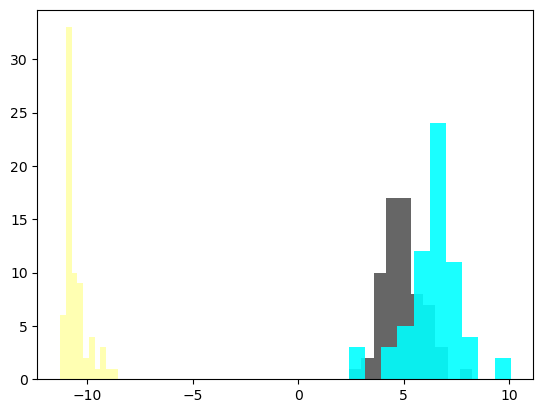

In [169]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA(n_components=1)
results = model.fit_transform(features,labels).reshape(-1)
color = ['yellow','black','aqua','green','teal','orange','navy','pink','purple','red']
for i in range(3):
    plt.hist(results[np.where(labels==i)[0]],color=color[i],alpha=(i+1)*0.3)
plt.show()

因此改成降到2维

In [170]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
LDA_model = LDA(n_components=2)
results = LDA_model.fit_transform(features,labels)

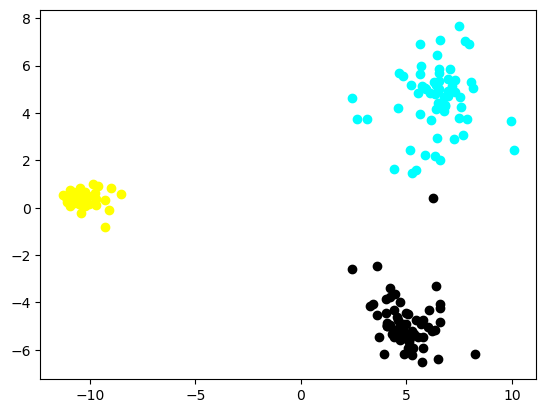

In [171]:
color = ['yellow','black','aqua','green','teal','orange','navy','pink','purple','red']
plt.figure()
for i in range(len(labels)):
    plt.scatter(results[i][0],results[i][1],color=color[labels[i]])
plt.show()

In [81]:
# 应该本来就有归一化操作，本步骤不需要
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# results = ss.fit_transform(results)


训练一个SVM分类器

In [172]:
from sklearn import svm
# ===================== train =====================
SVM_model = svm.SVC()
SVM_model.fit(results,labels)
predict = SVM_model.predict(results)
train_acc = np.sum(np.where(predict==labels))/len(labels)
train_acc

98.68

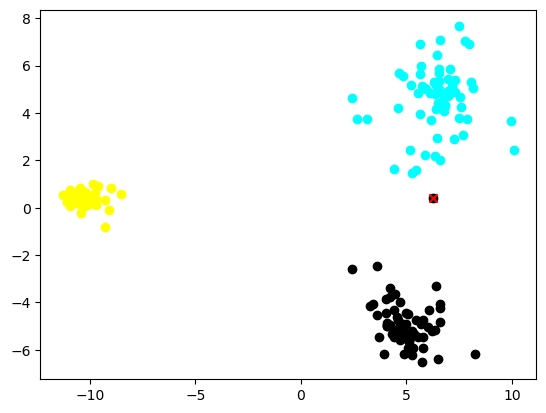

In [173]:
color = ['yellow','black','aqua','green','teal','orange','navy','pink','purple','red']
wrong_index = np.where(predict!=labels)[0]
plt.figure()
for i in range(len(labels)):
    plt.scatter(results[i][0],results[i][1],color=color[labels[i]])
for i in wrong_index:
    plt.scatter(results[i][0],results[i][1],color='red',marker='x')
plt.show()

测试Features-MDA模型效果

In [174]:
# --------------------- load data ---------------------
test_dataset = hrrpDataset(test_path, train=False, transform=transform)
samples = []
for i in range(len(test_dataset)):
    samples.append(test_dataset[i])
test_features,test_labels = zip(*samples)
test_features = np.array(test_features)
test_labels = np.array(test_labels)
test_results = LDA_model.transform(test_features)
# test_results = ss.fit_transform(test_results)
# --------------------- predict ---------------------
test_predict = SVM_model.predict(test_results)
test_acc = np.sum(np.where(test_predict==test_labels))/len(labels)

train_acc, test_acc

(98.68, 50.21)

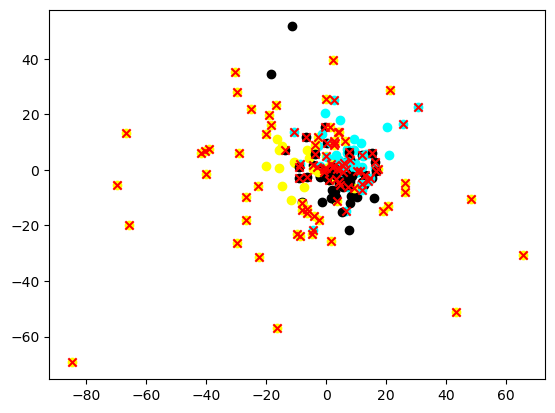

In [175]:
color = ['yellow','black','aqua','green','teal','orange','navy','pink','purple','red']
wrong_test_index = np.where(test_predict!=test_labels)[0]
plt.figure()
for i in range(len(labels)):
    plt.scatter(test_results[i][0],test_results[i][1],color=color[test_labels[i]])
for i in wrong_test_index:
    plt.scatter(test_results[i][0],test_results[i][1],color='red',marker='x')

plt.show()

若不降维，直接用SVM

In [176]:
SVM_model2 = svm.SVC()
SVM_model2.fit(features,labels)
predict = SVM_model2.predict(features)
train_acc = np.sum(np.where(predict==labels))/len(labels)

test_predict = SVM_model2.predict(test_features)
test_acc = np.sum(np.where(test_predict==test_labels))/len(labels)

train_acc, test_acc

(90.015, 83.86)

### 统计特征

### 物理特征

#### 长度特征

通常情况下, 散射点的强度大于噪声水平, 因此, 采用门限检测的方法进行散射点分离, 其中门限 $\eta$ 的计算方法如下:

$$
y = \mu * sqrtRoot(y)
$$

In [ ]:
y =hrrp[0]
sqrt_root = np.sqrt(np.mean(y**2))  # sqrt root

plt.figure()
plt.plot(y)
plt.plot([sqrt_root for i in range(len(y))])

可见，无论阈值系数怎么取，要么会丢失特征，要么会将噪声区间计入目标长度求解区间，因此先进行滑动平均进行滤波

<!--考虑到目标的回波幅值远大于噪声幅值，可以在滑动平均之前对hrrp进行平方处理，以放大目标对结果的影响--!>

In [ ]:
def sliding_average(x,N):
    weights = np.ones(N)/N
    return np.convolve(weights,x,'same')


N = 9
mu = 1
y =hrrp[1]
eta = mu*np.sqrt(np.mean(y**2))

slide_y = sliding_average(y,N)  # 均值滤波 :1:
slide_square_y = sliding_average(y**2,N*2)
import scipy.signal as sig  # 中值滤波
med = sig.medfilt(y,N)

plt.figure()
plt.plot(y,label='raw')
plt.plot(slide_y,label='slide')
plt.plot(med,label='median')
plt.plot(slide_square_y,label='slide square')
plt.plot([eta for i in range(len(y))],label='threshold')
plt.legend()

接下来采用均值滤波获取数据长度

In [ ]:
def sliding_average(x,window):
    weights = np.ones(window)/window
    return np.convolve(weights,x,'same')

def get_target(raw_hrrp,window=10):
    eta = mu*np.sqrt(np.mean(raw_hrrp**2))  # threshold
    slide = sliding_average(raw_hrrp,window)    # sliding average
    # tmp = np.nonzero(slide>eta)[0]
    tmp = np.where(slide>eta)[0]
    start,end = tmp[0],tmp[-1]      # choose the first and last bin
    return start,end

raw_hrrp = hrrp[1]
get_target(raw_hrrp)

#### 质心

In [ ]:
def get_center_of_mass(hrrp):
    return np.sum(np.multiply(hrrp,np.arange(1,len(hrrp)+1)))/np.sum(hrrp)

get_center_of_mass(hrrp[0])

#### 能量

In [ ]:
def get_energy(hrrp):
    return np.sum(hrrp**2)

#### 峰值

[参考链接](https://blog.csdn.net/chehec2010/article/details/117336967)

In [ ]:
from scipy.signal import find_peaks

x = hrrp[1]
peaks, _ = find_peaks(x,height=0.08)
peaks0, _ = find_peaks(x)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(peaks0, x[peaks0], "+")
plt.show()

In [ ]:
peak_value = x[peaks]
tmp = np.argsort(peak_value)    # the index of sorted peak_value (ascending)
dpk = 0 if len(peaks)<2 else peaks[tmp[-1]]-peaks[tmp[-2]]
dep = len(x)- peaks[tmp[-1]]
dpk,dep

In [ ]:
# 另一种找目标的方法：通过峰值查找
start = peaks0[np.where(peaks0==peaks[0])[0].item()-1]  # 前一个小峰
end = peaks0[np.where(peaks0==peaks[-1])[0].item()+1]    # 后一个小峰
start = 0 if start<0 else start
end = len(x)-1 if end>=len(x) else end
start,end

#### 分布熵

In [ ]:
np.log2(np.array([2,10,100]))

### 变换域

## 1D-CNN

### 模型搭建

In [ ]:
class oneD_CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(5,1),stride=(1,1),padding=(2,0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(5,1),stride=(1,1),padding=(2,0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1,2))
        )
        self.out = nn.Sequential(
            nn.Linear(32*64,3),
            nn.Softmax(dim=1)
        )

    def forward(self,x,out_layer=False):
        '''
            output_layer: 当该参数为True时，返回各中间层的参数结果(dict)；否则直接返回预测结果
        '''
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = x2.view(x2.shape[0],-1)
        x3 = self.out(x3)
        return {'layer1':x1,'layer2':x2,'output':x3} if out_layer else x3

def accurate_labels(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum().item()
    return rights, len(labels) 

### 模型训练

In [ ]:
model = oneD_CNN()
loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

train_acc = []
val_acc = []
losses = []
for epoch in range(epochs):
    # --------------------- train ---------------------
    model.train()
    right_,losses_ = [],[]
    for x,y in train_dl:
        predict_y = model(x)
        loss = loss_func(predict_y,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        right_.append(accurate_labels(predict_y,y)) # [(rights,len(labels)),(),(),...]
        losses_.append((loss.item()))

    right_,num = zip(*right_)
    train_acc.append(np.sum(right_)/np.sum(num))
    losses.append(np.sum(np.multiply(losses_,num))/np.sum(num))

    # --------------------- valid ---------------------
    model.eval()
    with torch.no_grad():
        right_,num = zip(*[accurate_labels(model(x),y) for x,y in test_dl])
        val_acc.append(np.sum(right_)/np.sum(num))
    
    if epoch%epochs_log==0:  
        print('[epoch {}/{}] loss:{}, train_acc:{}, val_acc:{}'.format(epoch,epochs,losses[epoch],train_acc[epoch],val_acc[epoch]))

### 结果可视化

#### loss & accuracy

In [ ]:
plt.figure(figsize=(8,4))
plt.tight_layout(pad=2)

plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel('epochs'); plt.ylabel('loss'); plt.title('loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='train')
plt.plot(val_acc,label='valid')
plt.xlabel('epochs'); plt.ylabel('accuracy'); plt.title('accuracy'); plt.legend()

#### 中间层可视化

In [ ]:
# 取一个数据
x,y = next(iter(test_dl))   # 一个batch torch.Size([bs,1,1,256]), torch.Size([bs])
x = x[0][None,:,:,:]        # torch.Size([1,1,1,256])

middle_output = model(x,out_layer=True)
for k in middle_output:
    print(k,': ',middle_output[k].shape)

In [ ]:
plt.matshow(x[0][0])
plt.matshow(middle_output['layer1'].detach().squeeze(0).squeeze(1))
plt.matshow(middle_output['layer2'].detach().squeeze(0).squeeze(1))

## BiLSTM